### Use this file to test the models mCNN, ResVe and off-the-shelf ResNet

In [1]:
from __future__ import print_function
from __future__ import division

import sys
import torch
import torch.utils.data as data
import os
import time
import pickle
import numpy as np
from PIL import Image
import re
import io
import os 

import json
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors


from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim

import itertools
import collections
import pdb

torch.manual_seed(42)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
cuda

True

In [2]:
# Path for file dset_dataloader.json
def open_json(path):
    f = open(path) 
    data = json.load(f) 
    f.close()
    return data 

def save_json(file_path, data):
    out_file = open(file_path, "w")
    json.dump(data, out_file)
    out_file.close()

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

### Bar to visualize progress

In [3]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

### File paths

In [4]:
# IMAGES
im_path_fur = '/home/ubuntu/ADARI/images/v2/full'

# WORD EMBEDDINGS
word_embeddings_path = "../json_files/fur_5c_50d_sk_glove_ft.json"
word_embeddings_path2 = "../json_files/fur_v2_5c_50d_adjs.json"

# IMAGE EMBEDDINGS
img_embds_id_p = "../json_files/afur_resnet_emb_id.json"
img_embds_name_p = "../json_files/afur_resnet_emb_names.json"

# FILES FOR DATALOADER
dset_words_p = "../json_files/ADARI_furniture_words.json"
vocab_p = "../json_files/ADARI_furniture_vocab_adjs.json"

In [5]:
# Open json files with embeddings 
image_embeddings = open_json(img_embds_name_p) 
dataset_labels = open_json(dset_words_p)        # dictionary image: list of adjectives 
labels_embeddings = open_json(word_embeddings_path)
labels_embeddings_v2 = open_json(word_embeddings_path2)
vocab = open_json(vocab_p)                      # vocab only adjectives 

In [6]:
def sampling_rate_and_negative_sample(vocab, w2i):
    # Returns sampling rate of word (prob of keeping the word ) and negative sampling rate
    # 1) variables for sampling_rate
    
    frequencies_ids = dict()
    frequencies = dict()
    total_number_words = sum(vocab.values())
    threshold = 1e-5
    for word, count in vocab.items():
        # for sampling rate 
        z_w = count / total_number_words # this all add up to 1
        frequencies[word] = z_w
        w_id = w2i[word]
        frequencies_ids[w_id] = z_w

    # Noise_dist
    noise_dist = {key:val**(3/4) for key, val in frequencies.items()}
    
    # Frequency of dropping
    p_drop = {word: 1 - np.sqrt(threshold/frequencies[word]) for word in vocab}
    
    # Noise dist normalized 
    Z = sum(noise_dist.values())
    neg_sampling = dict()
    neg_sampling_ids = dict()
    
    for k, v in noise_dist.items():
        k_id = w2i[k]
        n_s_value = v/Z
        neg_sampling[k] = n_s_value
        neg_sampling_ids[k_id] = n_s_value

    return frequencies, frequencies_ids, neg_sampling, neg_sampling_ids, p_drop

In [7]:
def im2idx_w2idx(im_words, vocab):
    # The 2 dictionaries below for dataset dataloader
    im2idx = dict()
    idx2im = dict()
    w2i = dict()
    i2w = dict()
    for i,image_name in enumerate(im_words.keys()):
        im2idx[image_name] = i
        idx2im[i] = image_name

    for i, w in enumerate(vocab.keys()):
        w2i[w] = i
        i2w[i] = w
    
    return im2idx, idx2im, w2i, i2w

In [8]:
im2id, id2im, w2i, i2w = im2idx_w2idx(dataset_labels, vocab)
s_rate, s_rate_ids, n_rate, n_rate_ids, p_drop = sampling_rate_and_negative_sample(vocab, w2i)

### Split dataset into train, validation and test

In [9]:
import random

def shuffle_dict(d):
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)
    return d

def splitDict(d_img_words, percent, val_number):

    val_n = val_number
    train_test_size = len(d_img_words) - val_n
    train_n = int(train_test_size*percent)
    test_n = train_test_size - train_n
    
    d_img_words = shuffle_dict(d_img_words)
    
    im_words = iter(d_img_words.items())      
    
    # Image - words
    dtrain = dict(itertools.islice(im_words, train_n))  
    dtest= dict(itertools.islice(im_words, test_n))   
    dval= dict(itertools.islice(im_words, val_n))
    
    # Save jsons 
    path = './train_test_val_mCNN/'
    os.makedirs(path)
    save_json('./train_test_val_mCNN/trainset.json', dtrain)
    save_json('./train_test_val_mCNN/testset.json', dtest)
    save_json('./train_test_val_mCNN/valset.json', dval)

    print('trainset size: ', len(dtrain), 'trainset dataset size: ',len(dtest), 'val set size: ', len(dval))
    return dtrain, dtest, dval

### If already created the split dataset, just load the json files

In [10]:
dtrain_w = open_json('./train_test_val_mCNN/trainset.json')
dtest_w = open_json('./train_test_val_mCNN/testset.json')
dval_w = open_json('./train_test_val_mCNN/valset.json')

In [11]:
img_size = 64
class ADARIdataset(Dataset):
    """
    Receives images and labels.
    Returns tensor image and tensor labels
    """
    def __init__(self, labels_data, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, img_path):

        self.labels_data = labels_data   # dictionary of images -> labels
        
        self.images_names = list(self.labels_data.keys())    # names
        self.images_embeds = list(image_embeddings.values()) # values
        
        self.w2i = w2i
        self.i2w = i2w
        self.im2id = im2id
        self.id2im = id2im
        
        self.sampling_r = s_rate
        self.neg_sampling = n_rate
        self.pdrop = p_drop
        
        self.image_path = img_path
        self.number_adjs = 10
        
    def __len__(self):
        return len(self.images_names)
    
    def get_image_tensor(self, image_name):
        """
        Gets image name and returns a tensor
        """
        name = self.image_path + "/" + image_name
        img = Image.open(name)
        img = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor()])(img)
        
        return img
        
    def get_labels_embeddings_from_idx(self, idx):

        name_image = self.images_names[idx]
        labels = self.labels_data[name_image]
        
        # Set random distribution for setting a max number of labels = 10
        labels1 = np.random.choice(labels, self.number_adjs)
        labels2 = np.random.choice(labels, self.number_adjs)
        
        pos1_idxs = [self.w2i[l] for l in labels1]
        pos2_idxs = [self.w2i[l] for l in labels2]
        
        # Get positive and negative labels
        all_idx = list(self.w2i.values())
        pos_idxs = []
        
        # Remove indexes that correspond to the positive labels
        for l in labels:
            v2i = self.w2i[l]
            pos_idxs.append(v2i)
            
            if v2i in all_idx:
                all_idx.remove(v2i)
        
        neg_idxs = np.random.choice(all_idx, self.number_adjs) #, p=neg_s_norm)
        
        neg_samples = []
        for n in neg_idxs:
            neg_samples.append(self.i2w[n])

        assert(len(labels1) == len(neg_samples))
        
        return torch.LongTensor(pos1_idxs), torch.LongTensor(pos2_idxs), torch.LongTensor(neg_idxs)
    
    def __getitem__(self, index):
        """
        Return tensor image and label index
        """
        name_image = self.images_names[index]
        img = self.get_image_tensor(name_image)
        
        # Get embeddigns of labels
        pos1_idxs, pos2_idxs, neg_idxs = self.get_labels_embeddings_from_idx(index) # list size variable 
        return img, pos1_idxs, pos2_idxs, neg_idxs, name_image
 

In [12]:
dataset_train = ADARIdataset(dtrain_w, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)
dataset_test = ADARIdataset(dtest_w, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)
dataset_val = ADARIdataset(dval_w, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)


In [13]:
batch_size = 64
num_workers = 8 if cuda else 0

In [14]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

## METRICS

In [15]:
def R_at_K_batch(ground_truth, predictions, K):
    """
    ground_truth and predictions are [batch, 20]
    """
    print('gt: ', ground_truth.shape)
    print(ground_truth)
    print('pred: ', predictions.shape)
    print(predictions)
    batch = ground_truth.shape[0]
    running_batch = 0.0
    for b in range(batch):
        res = R_at_K(ground_truth[b], predictions[b], K)
        running_batch += res
    return running_batch / batch
    
def R_at_K(ground_truth, predictions, K):
    """
    Ground truth: vector with 10 idxs
    Predictions: vector with 10 idxs
    """
    ground_truth = ground_truth.tolist()
    predictions = predictions.tolist()
    total_right = 0
    for pred in predictions[:K]:
        if pred in ground_truth:
            total_right += 1
    r_at_k = total_right / len(ground_truth)
    return r_at_k

In [16]:
def make_one_hot(vector, N):
    """
    Return multihot vector with N entries
    """
    batch = vector.shape[0]
    onehot = torch.zeros(batch, N, device=device).scatter_(1, vector.to(device), 1.)
    return onehot

In [17]:
def make_one_hot_onevector(vector, N):
    """
    Use this if batch=1
    Return multihot vector with N entries
    """
    onehot = torch.zeros(N, device=device)
    for idx in vector:
        onehot[idx] = 1.0
    return onehot

In [18]:
def calculate_metrics(target, preds, batch):
    """
    Calculates f1, precision, accuracy, lraps, mAP, auc weighted and unweighted
    """
    # Metrics 
    N = len(vocab)
    target = make_one_hot_onevector(target, N)
    SAMPLE_WEIGHT = compute_sample_weight('balanced', target.to("cpu"))
    preds = make_one_hot_onevector(preds, N)
    
    # WEIGHTED 
    f1 = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro", sample_weight=SAMPLE_WEIGHT)*batch
    #precision = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples",sample_weight=SAMPLE_WEIGHT)*batch
    #accuracy = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(),sample_weight=SAMPLE_WEIGHT)*batch
    #lraps = label_ranking_average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(),sample_weight=SAMPLE_WEIGHT)*batch
    mAP = average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro",sample_weight=SAMPLE_WEIGHT)*batch
    auc = roc_auc_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro", sample_weight=SAMPLE_WEIGHT)*batch
    

    # UNWEIGHTED
    f1_ = f1_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro")*batch
    #precision_ = precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")*batch
    #accuracy_ = accuracy_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*batch
    #lraps_ = label_ranking_average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy())*batch
    mAP_ = average_precision_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro")*batch
    auc_ = roc_auc_score(target.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="macro")*batch

    
    return f1, mAP, auc, f1_, mAP_, auc_, 

## LOAD

In [51]:
# Metrics
from sklearn.metrics import precision_score, f1_score, accuracy_score, label_ranking_average_precision_score, average_precision_score, roc_auc_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from matplotlib.pyplot import figure, imshow, axis, savefig
from matplotlib.image import imread
from torchvision.transforms import ToPILImage
import warnings


In [69]:
def showImagesHorizontally(list_of_files, save_path=False):
    fig = figure(figsize=(20,20))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image)
        axis('off')
        if save_path != False:
            savefig(save_path, dpi=300)
            

In [67]:
def showImagesHorizontally(list_of_files, save_path=False):
    fig = plt.figure(figsize=(20,20))
    columns = len(list_of_files)
    for i, img in enumerate(list_of_files):
        plt.subplot(len(list_of_files) / columns + 1, columns, i + 1)
        image = imread(list_of_files[i])
        plt.imshow(image)
    if save_path != False:
        fig.savefig(save_path, dpi=300)
   # plt.show()

#### Load models and embeddings

In [83]:
IMAGE_EMBEDDINGS = open_json('./plots_stats_losses/mCNN_v4/mCNN_v4_image_embeddings.json')

In [84]:
WORD_EMBEDDINGS = open_json('./plots_stats_losses/mCNN_v4/mCNN_v4_word_embeddings.json')

## Evaluation

In [21]:
def label_retrieval_given_image_word_space(loader):
    """
    Given an Image I, get its representation.
    Find the N closest words in the word embedding modality.
    """
    
    running_corrects = 0.0
    running_precision = 0.0
    running_accuracy = 0.0
    running_lraps = 0.0
    running_map = 0.0
    running_auc = 0.0
    
    running_corrects_ = 0.0
    running_precision_ = 0.0
    running_accuracy_ = 0.0
    running_lraps_ = 0.0
    running_map_ = 0.0
    running_auc_ = 0.0
    running_r_at_k = [0.0, 0.0, 0.0]
    running_r_at_k_random = [0.0, 0.0, 0.0]
    
    result = []
    result_ = []
    emb_words = list(WORD_EMBEDDINGS.keys())
    embeds = list(WORD_EMBEDDINGS.values())
    word_embeddings_np = np.asarray(embeds)
    
    neigh = NearestNeighbors(n_neighbors=20) # initilize algorithm
    neigh.fit(word_embeddings_np)           # fit population (words)
    
    with torch.no_grad():
        for batch_idx, (data, pos1_idxs, pos2_idxs, neg_idxs, name_image) in enumerate(loader):
            
            # Data to device 
            data = data.to(device)
            targets = dataset_labels[name_image[0]] # all true labels of image I 
            targets = np.asarray([w2i[w] for w in targets])
            targets = torch.from_numpy(targets)
            
            # image_CNN
            im_repres = IMAGE_EMBEDDINGS[name_image[0]]
            
            # Get label predictions (K-neighbors words of the image embedding)
            d, wids = neigh.kneighbors(np.asarray(im_repres))   # find the 10 nearest words to the image
            preds_np = wids.squeeze()#.tolist() # array of indices type Long (int)
            preds = torch.from_numpy(preds_np)
            random_neighboring_labels = np.random.randint(0, len(w2i), len(preds_np))
            
            K = [1,5,10]
            r_at_k_list = []
            r_at_k_randn = []
            
            for k in K:
                # preds
                r_at_k = R_at_K(targets, preds, k)
                r_at_k_list.append(r_at_k)
                # random
                r_at_k_random = R_at_K(targets, random_neighboring_labels, k) # Searching in image space
                r_at_k_randn.append(r_at_k_random)

            for i, ratk in enumerate(r_at_k_list):
                running_r_at_k[i] += ratk 
                running_r_at_k_random[i] += r_at_k_randn[i] 

            f1,  mAP, auc, f1_, mAP_, auc_ = calculate_metrics(targets.long(), preds, data.shape[0])

            running_corrects += f1
            running_map += mAP
            running_auc += auc

            running_corrects_ += f1_
            running_map_ += mAP_
            running_auc_ += auc_

               
    # Epoch metrics 
    epoch_f1 = running_corrects / len(loader.dataset)
    epoch_auc = running_auc / len(loader.dataset)
    epoch_map = running_map / len(loader.dataset)
    
    epoch_f1_ = running_corrects_ / len(loader.dataset)
    epoch_auc_ = running_auc_ / len(loader.dataset)
    epoch_map_ = running_map_ / len(loader.dataset)
    
    # R@K metric
    for r in running_r_at_k:
        r = r/len(loader)
    for r in running_r_at_k_random:
        r = r/len(loader)
    
    print('------ Evaluation -----')
    result1 = 'WEIGHTED F1: {:.4f} AUC: {:.4f} mAP: {:.4f}'.format(epoch_f1, epoch_auc, epoch_map)
    print(result1)
    result2 = 'UNWEIGHTED F1: {:.4f} AUC: {:.4f} mAP: {:.4f}'.format(epoch_f1_, epoch_auc_, epoch_map_)
    print(result2)
    ratk_eval = 'R@K=1: {:.4f}  R@K=5: {:.4f} R@K=10: {:.4f}'.format(running_r_at_k[0], running_r_at_k[1], running_r_at_k[2])
    ratk_eval_r = 'Random R@K=1: {:.4f}  R@K=5: {:.4f} R@K=10: {:.4f}'.format(running_r_at_k_random[0], running_r_at_k_random[1], running_r_at_k_random[2])
    print(ratk_eval)
    print(ratk_eval_r)
    return result1, result2, ratk_eval, ratk_eval_r


In [22]:
def label_retrieval_given_image_image_space(loader, N_neighbors=5):
    """
    Given an image M, and its ground truth labels L, get N nearest neighbor images. 
    For each image I in N gets:
        Ground truth labels (GTL) of I: GTL length varies
    All GTL are appended to a list ALL_GTL
    Calculate R@K with K = {1, 5, 10}. Given a list of ground truth labels of M, and a varying length list of retrieved
    labels from the closest N images, calculate the proportion of labels in ALL_GTL that are in L in the top-K. 
    
    """

    running_r_at_k = [0.0, 0.0, 0.0]
    running_r_at_k_random = [0.0, 0.0, 0.0]
    running_map = 0.0
    running_map_r = 0.0
    
    result = []
    result_ = []

    # Get all image embeddings 
    im_embds_name = list(IMAGE_EMBEDDINGS.keys())  # names
    im_embds_emb = list(IMAGE_EMBEDDINGS.values()) # embeddings
    im_embeddings_np = np.asarray(im_embds_emb).squeeze(1) # [17532, 50]
   
    # init nearest neighbors
    neigh_im = NearestNeighbors(n_neighbors=N_neighbors)
    neigh_im.fit(im_embeddings_np)
    
    contain_query = False
    with torch.no_grad():
        for batch_idx, (data, pos1_idxs, pos2_idxs, neg_idxs, name_image) in enumerate(loader):
            
            # Data to device 
            data = data.to(device)
            
            # image_CNN
            im_repres = IMAGE_EMBEDDINGS[name_image[0]]
            targets = np.asarray(dataset_labels[name_image[0]]) # all true labels of image I 

            # Get label predictions from neighboring images 
            d, im_ids = neigh_im.kneighbors(np.asarray(im_repres))# neighbors of image. Return indexes
            im_ids = im_ids.squeeze()
            
            # get image names + labels of each image
            all_neighboring_image_labels = []
            all_neighboring_image_labels_idxs = []
            for imid in im_ids:
                im_name = im_embds_name[imid]
                if im_name == name_image[0]:
                    contain_query = True
                    continue
                im_labels = dataset_labels[im_name] # list
                all_neighboring_image_labels += im_labels
                for l in im_labels:
                    all_neighboring_image_labels_idxs.append(w2i[l])
            
            random_neighboring_labels = np.random.randint(0, len(w2i), len(all_neighboring_image_labels_idxs))
            all_neighboring_image_labels = np.asarray(all_neighboring_image_labels)
            
            # Metrics for labels of neighboring words 
            K = [1,5,10]
            r_at_k_list = []
            r_at_k_randn = []
            
            for k in K:
                r_at_k = R_at_K(targets, all_neighboring_image_labels, k) # Searching in image space
                r_at_k_random = R_at_K(targets, random_neighboring_labels, k) # Searching in image space
                r_at_k_list.append(r_at_k)
                r_at_k_randn.append(r_at_k_random)
                
            for i, ratk in enumerate(r_at_k_list):
                running_r_at_k[i] += ratk 
                running_r_at_k_random[i] += r_at_k_randn[i] 
            
            targets = torch.LongTensor([w2i[t] for t in targets])
            targets = make_one_hot_onevector(targets, len(vocab))
            preds = make_one_hot_onevector(all_neighboring_image_labels_idxs, len(vocab))
            randn = torch.randn_like(preds)
            mAP = average_precision_score(targets.to("cpu").to(torch.int).numpy(), preds.to("cpu").to(torch.int).numpy(), average="samples")
            mAP_r = average_precision_score(targets.to("cpu").to(torch.int).numpy(), randn.to("cpu").to(torch.int).numpy(), average="samples")
            running_map += mAP
            running_map_r += mAP_r
    
    # R@K metric
    for r in running_r_at_k:
        r = r/len(loader)
    for r in running_r_at_k_random:
        r = r/len(loader)
    
    epoch_map = running_map / len(loader)
    epoch_map_r = running_map_r / len(loader)
    
    print('------ Evaluation -----')
    ratk_eval = 'R@K=1: {:.4f}  R@K=5: {:.4f} R@K=10: {:.4f}'.format(running_r_at_k[0], running_r_at_k[1], running_r_at_k[2])
    ratk_eval_r = 'Random R@K=1: {:.4f}  R@K=5: {:.4f} R@K=10: {:.4f}'.format(running_r_at_k_random[0], running_r_at_k_random[1], running_r_at_k_random[2])
    map_eval = 'mAP: {:.4F}'.format(epoch_map)
    map_r_eval = 'Random mAP: {:.4F}'.format(epoch_map_r)
    print(ratk_eval)
    print(ratk_eval_r)
    print(map_eval)
    print(map_r_eval)
    print('contain query: ', contain_query)
    return ratk_eval, ratk_eval_r, map_eval

In [34]:
def label_retrieval_given_intent_image_space(loader, DESIGN_INTENT, visualize=False, N_neighbors=10):
    """
    Given a design intent W, get N nearest neighbor images. 
    For each image I in N gets:
        Ground truth labels (GTL) of I: GTL length varies
    All GTL are appended to a list ALL_GTL
    Calculate R@K with K = {1, 5, 10}. Given the design intent W, and a varying length list of retrieved
    labels from the closest N images, calculate the proportion of labels in ALL_GTL that match W in the top-K. 
    
    """

    # Get all image embeddings 
    im_embds_name = list(IMAGE_EMBEDDINGS.keys())  # names
    im_embds_emb = list(IMAGE_EMBEDDINGS.values()) # embeddings
    im_embeddings_np = np.asarray(im_embds_emb).squeeze(1) # [17532, 50]
    
    # design intent embedding       
    design_intent_embedding = np.asarray(WORD_EMBEDDINGS[DESIGN_INTENT]).reshape(1, -1) # [1, 50]

    # Inititate KNN
    neigh_im = NearestNeighbors(n_neighbors=N_neighbors)
    neigh_im.fit(im_embeddings_np)
    d, im_ids = neigh_im.kneighbors(design_intent_embedding) # neighbors of design intent. Return indexes
    im_ids = im_ids.squeeze()
    
    # get image names + labels of each image
    imgs = [] 
    all_neighboring_image_labels = []
    design_intent_match = [False] * N_neighbors
    
    ii = 0
    pred = 0
    for imid in im_ids:
        im_name = im_embds_name[imid]
        im_labels = dataset_labels[im_name] # list
        all_neighboring_image_labels.append(im_labels)
        if DESIGN_INTENT in im_labels:
            design_intent_match[ii] = True
            pred += 1
        full_path = im_path_fur + '/' + im_name
        imgs.append(full_path)
        ii +=1
    
    if visualize:
        showImagesHorizontally(imgs)
        plt.show()
        print(design_intent_match)
        print(all_neighboring_image_labels)
    
    return pred


In [76]:
def label_retrieval_given_image_image_space_visualizer(loader):

    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    predictions = []
    ground_truth = []

    # IMAGES Nearest Neighbors
    im_embds_name = list(IMAGE_EMBEDDINGS.keys())  # names
    im_embds_emb = list(IMAGE_EMBEDDINGS.values()) # embeddings
    im_embeddings_np = np.asarray(im_embds_emb).squeeze(1) # [17532, 50]
    
    neigh_im = NearestNeighbors(n_neighbors=6)
    neigh_im.fit(im_embeddings_np)
    
    TOTAL_PREDICTED = 0
    with torch.no_grad():
        #       img , word emb 1, word emb 2   , neg word emb,  word idx 1, word idx 2, neg word idx, image name 
        for i, (data, pos1_idxs, pos2_idxs, neg_idxs, img_names) in enumerate(loader):
            if i == 2: break
            data = data.to(device)
            
            # Get original words belonging to the image
            ground_truth = dataset_labels[img_names[0]]

            # Visualize image
            ima = ToPILImage()(data.detach().cpu().squeeze(0)) 
                       
            # Get representation of image
            emb_im = np.asarray(IMAGE_EMBEDDINGS[img_names[0]])
            
            # Fit the query in the image space  
            d, im_ids = neigh_im.kneighbors(emb_im)
            
            im_ids = im_ids.squeeze()
            imgs = [im_path_fur + '/' + img_names[0]] # first image is the test image 
            imgs_labels = []
            imgs_labels_cluster = []
            
            PREDICTED = 0
            # get image names + labels of each image
            for imid in im_ids:
                im_name   =  im_embds_name[imid]
                if im_name == img_names[0]:
                    print('query in neighbors!')
                    continue # if it is the same! 
                im_labels = dataset_labels[im_name]
                per_image = []
                
                # iterate over each label per image and append if coincides with the ground truth 
                for il in im_labels:
                    if il in ground_truth:
                        per_image.append(il)
                        PREDICTED += 1
                
                imgs_labels_cluster.append(per_image)
                imgs_labels.append(im_labels)
                full_path = im_path_fur + '/' + im_name
                imgs.append(full_path)
            
            TOTAL_PREDICTED += PREDICTED   
            print('-----NEW QUERY------')
            print()
            print('true labels: ', ground_truth)
            showImagesHorizontally(imgs, 'offtheshelf_resnet_valset_{}.png'.format(i))
            plt.show()
            print()
            print('GT labels of neighboring images')
            print(imgs_labels)
            print()
            print('Clustering')
            print(imgs_labels_cluster)
            print('Total predicted: ', PREDICTED)
            print('-----------------------')
            print()
         
    print('Returning total predicted: {} in {} queries'.format(TOTAL_PREDICTED, 20))
    return TOTAL_PREDICTED

In [25]:
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=num_workers)

In [26]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=num_workers)

#### v4.1_resnet

In [79]:
IMAGE_EMBEDDINGS = open_json('./plots_stats_losses/mCNN_v4.1/mCNN_v4.1_image_embeddings_resnet.json')
WORD_EMBEDDINGS =  open_json('./plots_stats_losses/mCNN_v4.1/mCNN_v4.1_word_embeddings.json')

In [64]:
label_retrieval_given_image_word_space(test_dataloader)

------ Evaluation -----
WEIGHTED F1: 0.3344 AUC: 0.4995 mAP: 0.5007
UNWEIGHTED F1: 0.4992 AUC: 0.4995 mAP: 0.0036
R@K=1: 0.0000  R@K=5: 0.4337 R@K=10: 0.8485
Random R@K=1: 0.0526  R@K=5: 0.5010 R@K=10: 1.0393


('WEIGHTED F1: 0.3344 AUC: 0.4995 mAP: 0.5007',
 'UNWEIGHTED F1: 0.4992 AUC: 0.4995 mAP: 0.0036',
 'R@K=1: 0.0000  R@K=5: 0.4337 R@K=10: 0.8485',
 'Random R@K=1: 0.0526  R@K=5: 0.5010 R@K=10: 1.0393')

In [70]:
label_retrieval_given_image_image_space(test_dataloader)

------ Evaluation -----
R@K=1: 5.7709  R@K=5: 30.5042 R@K=10: 59.9018
Random R@K=1: 0.0000  R@K=5: 0.0000 R@K=10: 0.0000
mAP: 0.0569
Random mAP: 0.0039
contain query:  True


('R@K=1: 5.7709  R@K=5: 30.5042 R@K=10: 59.9018',
 'Random R@K=1: 0.0000  R@K=5: 0.0000 R@K=10: 0.0000',
 'mAP: 0.0569')

In [ ]:
label_retrieval_given_intent_image_space(val_dataloader, 'minimal')

In [37]:
intents = ['organic', 'dynamic', 'curved', 'minimal', 'light', 'heavy', 'futuristic', 'classic', 'white', 'thick']
guessed = 0
for intent in intents:
    guessed += label_retrieval_given_intent_image_space(val_dataloader, intent)
print(guessed)

6


query in neighbors!
-----NEW QUERY------

true labels:  ['chief', 'particular', 'striped', 'strong', 'industrial', 'last', 'original', 'thin', 'steel-sheet', 'high', 'fine', 'mid-century', 'round', 'danish', 'ongoing', 'light', 'true', 'city-wide', 'loop-shaped']


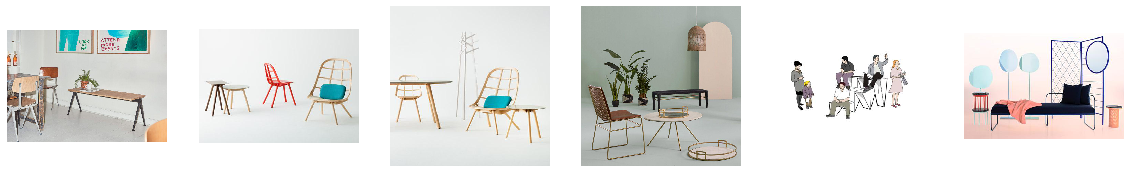


GT labels of neighboring images
[['curved', 'particular', 'branch-like', 'interlocked', 'natural', 'rounded', 'under', 'wooden', 'traditional', 'unsurprising', 'japanese', 'coloured', 'inherent', 'circular', 'pentagonal', 'padded', 'light', 'rectangular', 'maritime', 'bright', 'sturdy'], ['curved', 'particular', 'branch-like', 'interlocked', 'natural', 'rounded', 'under', 'wooden', 'traditional', 'unsurprising', 'japanese', 'coloured', 'inherent', 'circular', 'pentagonal', 'padded', 'light', 'rectangular', 'maritime', 'bright', 'sturdy'], ['brass-framed', 'cushion-covered', 'pale', 'modern', 'ancestral', 'contemporary', 'commercial', 'alone', 'traditional', 'residential', 'canadian', 'circular', 'female', 'round', 'close', 'versatile', 'different', 'architectural', 'veiny', 'cylindrical', 'indian', 'green'], ['multilevel', 'triangular', 'infinite', 'large', 'interior', 'stair-shaped', 'social', 'public', 'urban', 'prescribed', 'flexible', 'multiple'], ['topiary', 'prominent', 'horizon

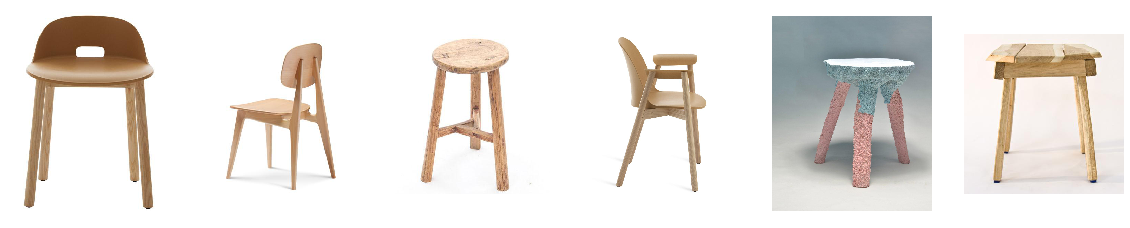


GT labels of neighboring images
[['danish', 'curved', 'forced', 'alpine', 'tapered', 'upholstered', 'grey', 'wooden', 'natural', 'traditional', 'black', 'red'], ['guardian', 'rich', 'oriental', 'sustainable', 'good', 'rectangular', 'chinese', 'high', 'beautiful', 'wooden', 'antique', 'deep', 'careful', 'surprised', 'skilled', 'round', 'regular', 'stoolsthese'], ['flat', 'rich', 'functional', 'german', 'fire-resistant', 'strong', 'italian', 'industrial', 'parisian', 'classic', 'simple', 'responsible', 'three-seater', 'further', 'non-corrosive', 'influential', 'smart', 'wooden', 'japanese', 'torpedo-proof', 'storyindustrial', 'comfortable', 'british', 'small', 'post-industrial', 'normal', 'wood-filled', 'spanish', 'light', 'early', 'retrospective', 'timeless', 'lightweight', 'amish'], ['negative', 'interesting', 'natural', 'urban', 'fluorescent', 'unique', 'gelatinous', 'synthetic', 'circular', 'sustainable', 'complete', 'multi-sensory', 'distinctive', 'high', 'undergraduate', 'unusual'

46

In [70]:
label_retrieval_given_image_image_space_visualizer(val_dataloader)

#### v4.2 

In [74]:
IMAGE_EMBEDDINGS = open_json('./plots_stats_losses/mCNN_v4.2/mCNN_v4.2_image_embeddings.json')
WORD_EMBEDDINGS =  open_json('./plots_stats_losses/mCNN_v4.2/mCNN_v4.2_word_embeddings.json')

In [68]:
label_retrieval_given_image_word_space(test_dataloader)

------ Evaluation -----
WEIGHTED F1: 0.3349 AUC: 0.4997 mAP: 0.5009
UNWEIGHTED F1: 0.4996 AUC: 0.4997 mAP: 0.0036
R@K=1: 0.0000  R@K=5: 0.4400 R@K=10: 0.7812
Random R@K=1: 0.0820  R@K=5: 0.7520 R@K=10: 1.4236


('WEIGHTED F1: 0.3349 AUC: 0.4997 mAP: 0.5009',
 'UNWEIGHTED F1: 0.4996 AUC: 0.4997 mAP: 0.0036',
 'R@K=1: 0.0000  R@K=5: 0.4400 R@K=10: 0.7812',
 'Random R@K=1: 0.0820  R@K=5: 0.7520 R@K=10: 1.4236')

In [72]:
label_retrieval_given_image_image_space(test_dataloader)

------ Evaluation -----
R@K=1: 3.6373  R@K=5: 18.2099 R@K=10: 33.8212
Random R@K=1: 0.0000  R@K=5: 0.0000 R@K=10: 0.0000
mAP: 0.0270
Random mAP: 0.0040
contain query:  True


('R@K=1: 3.6373  R@K=5: 18.2099 R@K=10: 33.8212',
 'Random R@K=1: 0.0000  R@K=5: 0.0000 R@K=10: 0.0000',
 'mAP: 0.0270')

In [ ]:
label_retrieval_given_intent_image_space(val_dataloader, 'minimal')

In [40]:
intents = ['organic', 'dynamic', 'curved', 'minimal', 'light', 'heavy', 'futuristic', 'classic', 'white', 'thick']
guessed = 0
for intent in intents:
    guessed += label_retrieval_given_intent_image_space(val_dataloader, intent)
print(guessed)

6


query in neighbors!
-----NEW QUERY------

true labels:  ['chief', 'particular', 'striped', 'strong', 'industrial', 'last', 'original', 'thin', 'steel-sheet', 'high', 'fine', 'mid-century', 'round', 'danish', 'ongoing', 'light', 'true', 'city-wide', 'loop-shaped']


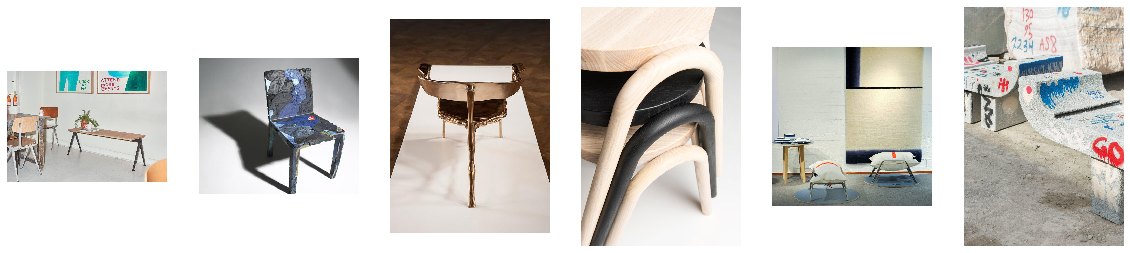


GT labels of neighboring images
[['infinite', 'recycled', 'current', 'old', 'unconscious'], ['shiny', 'ancient', 'old', 'digital', 'original', 'dutch', 'emaciated', 'uneven', 'thin', 'sustainable', 'technology-driven', 'hand-crafted', 'patinated', 'opposite', 'spindly', 'precious', 'large', 'skeletal', 'global', 'winged', 'mass-produced', 'metallic', 'back', 'green'], ['stackable', 'norwegian', 'recognisable', 'distinctive', 'light', 'dark', 'high', 'continuous', 'hidden', 'interesting', 'wooden', 'zigzag', 'classic', 'undulating', 'experimental', 'tubular', 'square', 'dynamic'], ['curved', 'natural', 'industrial', 'nautical-themed', 'old', 'hand-blown', 'contemporary', 'shared', 'coastal', 'wooden', 'traditional', 'tubular', 'inflatable', 'spiky', 'bare', 'imperfect', 'icelandic', 'large', 'skeletal', 'different', 'soluble', 'interactive', 'local', 'minimal', 'architectslatvian', 'seafaring', 'human'], ['functional', 'white', 'natural', 'huge', 'tbilisi-based', 'floor-standing', 'cog

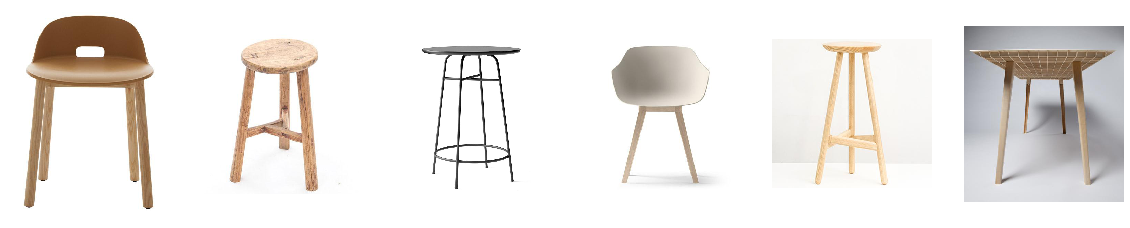


GT labels of neighboring images
[['guardian', 'rich', 'oriental', 'sustainable', 'good', 'rectangular', 'chinese', 'high', 'beautiful', 'wooden', 'antique', 'deep', 'careful', 'surprised', 'skilled', 'round', 'regular', 'stoolsthese'], ['stackable', 'aesthetic', 'white', 'bar-table', 'powder-coated', 'simple', 'lacquered', 'interconnected', 'tubular', 'tall', 'circular', 'slender', 'short', 'padded', 'three-legged', 'small', 'cafe-style', 'slim', 'patchwork', 'round', 'bent', 'danish', 'light', 'oblong', 'public', 'black', 'minimal'], ['renewable', 'basque', 'harmful', 'industrial', 'injection-moulded', 'semi-concave', 'mechanical', 'organic', 'plant-based', 'comfortable', 'sustainable', 'fundamental', 'biodegradable', 'finite', 'contrary', 'bio-based', 'wool-based', 'fossil', 'non-renewable', 'recyclable', 'solid'], ['stained', 'interior', 'functional', 'white', 'natural', 'powder-coated', 'current', 'simple', 'contemporary', 'original', 'latter', 'useful', 'ceramic', 'flush', 'colou

20

In [75]:
label_retrieval_given_image_image_space_visualizer(val_dataloader)

#### Off-the-shelf Resnet 

In [77]:
IMAGE_EMBEDDINGS = open_json('IMAGE_EMBEDDINGS_OFFTHESHELF_RESNET.json')

In [74]:
label_retrieval_given_image_image_space(test_dataloader)

------ Evaluation -----
R@K=1: 2.8376  R@K=5: 15.2965 R@K=10: 29.0696
Random R@K=1: 0.0000  R@K=5: 0.0000 R@K=10: 0.0000
mAP: 0.0193
Random mAP: 0.0040
contain query:  True


('R@K=1: 2.8376  R@K=5: 15.2965 R@K=10: 29.0696',
 'Random R@K=1: 0.0000  R@K=5: 0.0000 R@K=10: 0.0000',
 'mAP: 0.0193')

query in neighbors!
-----NEW QUERY------

true labels:  ['chief', 'particular', 'striped', 'strong', 'industrial', 'last', 'original', 'thin', 'steel-sheet', 'high', 'fine', 'mid-century', 'round', 'danish', 'ongoing', 'light', 'true', 'city-wide', 'loop-shaped']


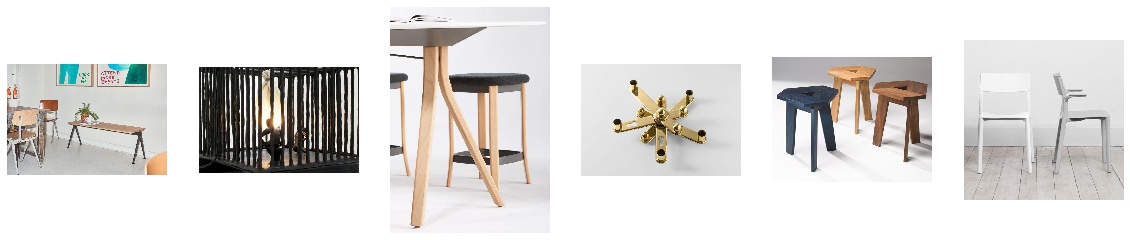


GT labels of neighboring images
[['multidisciplinary', 'self-sufficient', 'industrial', 'crucial', 'tribal', 'huge', 'ancient', 'contemporary', 'agricultural', 'open', 'collective', 'disposable', 'lifelong', 'diverse', 'sustainable', 'extreme', 'large-scale', 'practical', 'major', 'different', 'indestructible', 'hybrid', 'cannibalistic', 'provocative', 'alternative', 'sacrificial', 'human'], ['natural', 'technological', 'visual', 'open-plan', 'last', 'rounded', 'innovative', 'plush', 'traditional', 'square', 'dynamic', 'free', 'useless', 'compact', 'experimental', 'flexible', 'bent', 'neocon', 'common', 'mass', 'large', 'high-backed', 'social', 'oblong', 'public', 'semi-private', 'double'], ['stained', 'limited-edition', 'hard', 'natural', 'old', 'outdated', 'varnished', 'cirici-designed', 'polished', 'dark', 'coated', 'brass-coated', 'cristian', 'spanish', 'creative', 'large', 'loose', 'prestigious', 'untouched', 'unused', 'memorable', 'technical'], ['kidney-shaped', 'tri', 'white', 

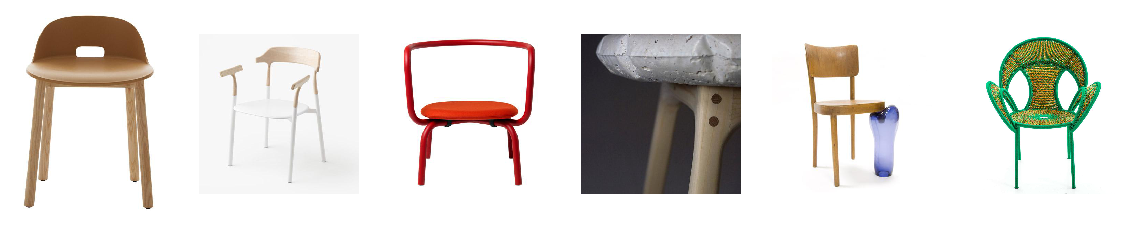


GT labels of neighboring images
[['different', 'italian', 'high', 'interchangeable', 'white', 'low', 'wooden', 'connected', 'artificial', 'prolific', 'japanese', 'minimal'], ['interior', 'german', 'pastel', 'effective', 'outdoor', 'italian', 'luxurious', 'deliberate', 'hard', 'recycled', 'industrial', 'classic', 'current', 'internal', 'modern', 'modest', 'little', 'heartfelt', 'material', 'innovative', 'international', 'anodized', 'original', 'perfect', 'optional', 'generous', 'wooden', 'grey', 'future', 'iconic', 'tubular', 'armed', 'much-copied', 'modular', 'american', 'subtle', 'clear', 'top', 'red', 'tractor-inspired', 'round', 'suitable', 'nice', 'analytical', 'thoughtful', 'real', 'danish', 'close', 'versatile', 'different', 'challenging', 'interested', 'angular', 'obvious', 'indoor', 'fresh', 'public', 'alternative', 'black', 'technical', 'peculiar', 'physical'], ['simple', 'versatile', 'light', 'different', 'interested', 'dutch', 'long', 'past', 'low', 'experimental', 'surpris

32

In [78]:
label_retrieval_given_image_image_space_visualizer(val_dataloader)

## Proving that the best model is not off-the-shelf RESNET

In [149]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc (classification) layer.
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        return features

In [153]:
def get_image_tensor(image_name, im_path):
    """
    Gets image name and returns a tensor
    """
    name = im_path + "/" + image_name
    img = Image.open(name)
    img = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()])(img)
    return img

def get_im_embeddings(im_path):
    im_embds_name = list(image_embeddings.keys())  # names
    im_embds_emb = list(image_embeddings.values()) # embeddings
    
    model = EncoderCNN().to(device)
    
    all_embeds = dict()
    for name in im_embds_name:
        im = get_image_tensor(name, im_path).unsqueeze(0)
        emb_im = model(im.to(device)).squeeze(3).squeeze(2).detach().cpu().numpy().reshape(1,-1) # [1,2048]
        all_embeds[name] = emb_im
    return all_embeds

# all_embeds = get_im_embeddings(im_path_fur)

In [154]:
new_d = dict()
for k,v in all_embeds.items():
    new_d[k] = v.tolist()

save_json('IMAGE_EMBEDDINGS_OFFTHESHELF_RESNET.json', new_d)

query in neighbors!
-----NEW QUERY------

true labels:  ['chief', 'particular', 'striped', 'strong', 'industrial', 'last', 'original', 'thin', 'steel-sheet', 'high', 'fine', 'mid-century', 'round', 'danish', 'ongoing', 'light', 'true', 'city-wide', 'loop-shaped']


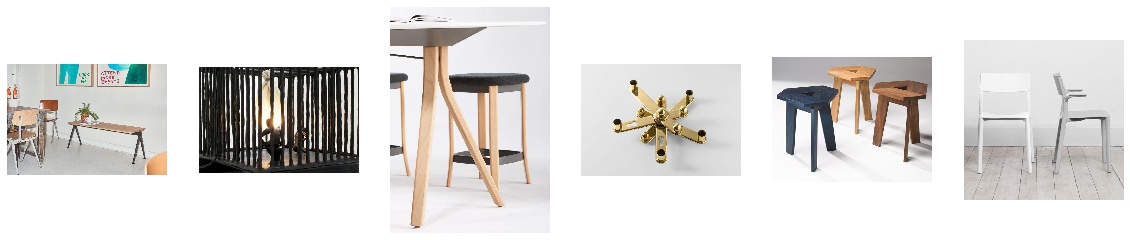


GT labels of neighboring images
[['multidisciplinary', 'self-sufficient', 'industrial', 'crucial', 'tribal', 'huge', 'ancient', 'contemporary', 'agricultural', 'open', 'collective', 'disposable', 'lifelong', 'diverse', 'sustainable', 'extreme', 'large-scale', 'practical', 'major', 'different', 'indestructible', 'hybrid', 'cannibalistic', 'provocative', 'alternative', 'sacrificial', 'human'], ['natural', 'technological', 'visual', 'open-plan', 'last', 'rounded', 'innovative', 'plush', 'traditional', 'square', 'dynamic', 'free', 'useless', 'compact', 'experimental', 'flexible', 'bent', 'neocon', 'common', 'mass', 'large', 'high-backed', 'social', 'oblong', 'public', 'semi-private', 'double'], ['stained', 'limited-edition', 'hard', 'natural', 'old', 'outdated', 'varnished', 'cirici-designed', 'polished', 'dark', 'coated', 'brass-coated', 'cristian', 'spanish', 'creative', 'large', 'loose', 'prestigious', 'untouched', 'unused', 'memorable', 'technical'], ['kidney-shaped', 'tri', 'white', 

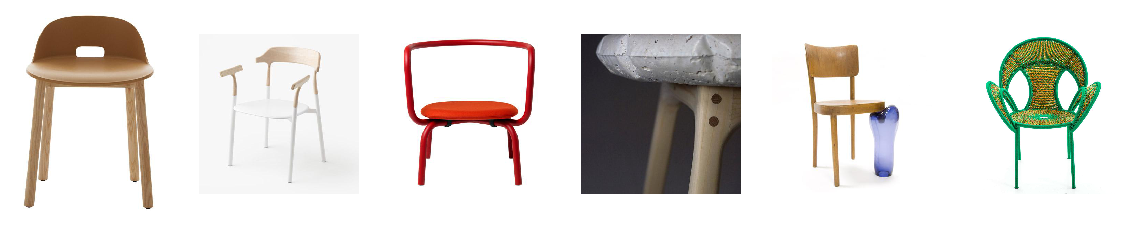


GT labels of neighboring images
[['different', 'italian', 'high', 'interchangeable', 'white', 'low', 'wooden', 'connected', 'artificial', 'prolific', 'japanese', 'minimal'], ['interior', 'german', 'pastel', 'effective', 'outdoor', 'italian', 'luxurious', 'deliberate', 'hard', 'recycled', 'industrial', 'classic', 'current', 'internal', 'modern', 'modest', 'little', 'heartfelt', 'material', 'innovative', 'international', 'anodized', 'original', 'perfect', 'optional', 'generous', 'wooden', 'grey', 'future', 'iconic', 'tubular', 'armed', 'much-copied', 'modular', 'american', 'subtle', 'clear', 'top', 'red', 'tractor-inspired', 'round', 'suitable', 'nice', 'analytical', 'thoughtful', 'real', 'danish', 'close', 'versatile', 'different', 'challenging', 'interested', 'angular', 'obvious', 'indoor', 'fresh', 'public', 'alternative', 'black', 'technical', 'peculiar', 'physical'], ['simple', 'versatile', 'light', 'different', 'interested', 'dutch', 'long', 'past', 'low', 'experimental', 'surpris

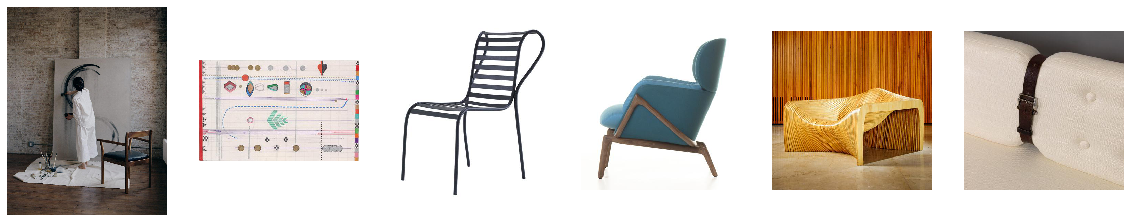


GT labels of neighboring images
[['shiny', 'horizontal', 'beige', 'non-precious', 'tribal', 'unique', 'joyful', 'hand-woven', 'vertical', 'traditional', 'due', 'coloured', 'inherent', 'unfinished', 'sensual', 'spontaneous', 'irreverent', 'long-standing', 'dark', 'skilled', 'spanish', 'different', 'rectangular', 'intricate', 'durable', 'random', 'metallic', 'handmade', 'black', 'multicoloured', 'hand-knotted', 'straight'], ['stackable', 'curved', 'poetic', 'distinctive', 'tubular', 'cooked', 'outdoor', 'white', 'french', 'indoor', 'fluid', 'optional', 'asymmetrical', 'lightweight', 'black', 'smooth', 'back', 'unique'], ['triangular', 'padded', 'northern', 'complementary', 'italian', 'danish-oiled', 'great', 'hand-crafted', 'wooden', 'hard', 'portuguese', 'crib-like', 'soft', 'outer', 'parallel', 'ceiling-mounted', 'european', 'american'], ['prominent', 'exclusive', 'offline', 'italian', 'pr', 'eligible', 'international', 'further', 'influential', 'open', 'juried', 'wide', 'special', 'e

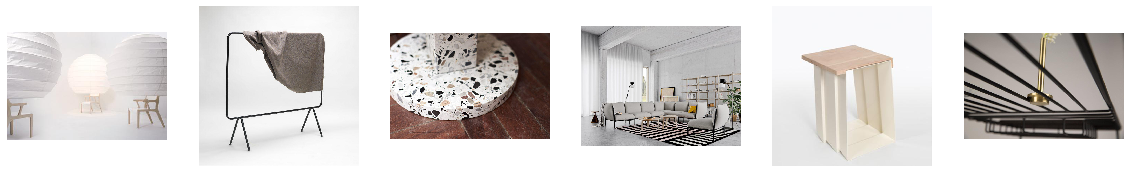


GT labels of neighboring images
[['stackable', 'bendy', 'german', 'yellow', 'white', 'sound-absorbing', 'familiar', 'simple', 'grey', 'wooden', 'sturdy', 'great', 'gridded', 'ordinary', 'autonomous', 'everyday', 'common', 'well', 'lightweight', 'cylindrical', 'miniature', 'black'], ['speckle-topped', 'italian', 'primo', 'cubic', 'dappled', 'mottled', 'endless', 'speckled', 'commercial', 'residential', 'coloured', 'popular', 'hand-cast', 'circular', 'small', 'sculptural', 'polished', 'creative', 'large', 'medium'], ['stackable', 'flat', 'woollen', 'curved', 'striped', 'cologne-based', 'swedish', 'strong', 'italian', 'least', 'powder-coated', 'single', 'big', 'last', 'joyful', 'simple', 'norwegian', 'alphabeta', 'inaugural', 'three-seater', 'innovative', 'international', 'prolific', 'three-metre-long', 'orderly', 'popular', 'modular', 'three-dimensional', 'running', 'in-house', 'experimental', 'textile', 'high-end', 'nice', 'geometric', 'different', 'true', 'loose', 'floor-lamp', 'detac

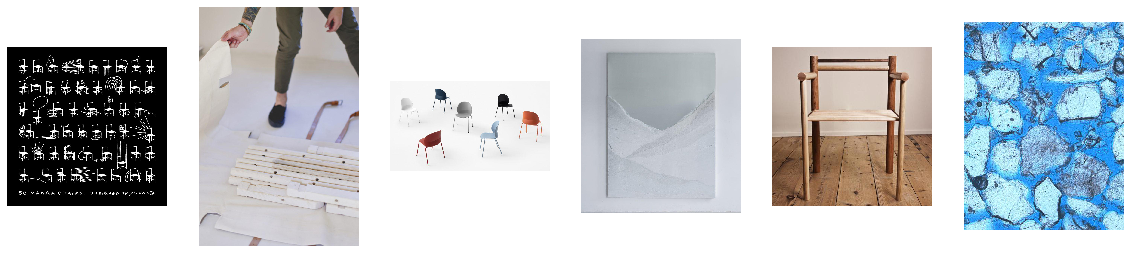


GT labels of neighboring images
[['carry', 'stackable', 'challenging', 'dutch', 'exciting', 'italian', 'emotional', 'nomadic', 'wooden', 'lightweight', 'hungarian', 'flexible', 'practical', 'modular', 'double'], ['stackable', 'accessible', 'scandinavian', 'low', 'recycled', 'big', 'scandanavian', 'elegant', 'simple', 'grey', 'wooden', 'japanese', 'blue', 'circular', 'earthy', 'nordic', 'high', 'four-legged', 'vaulted', 'characteristic', 'polished', 'dark', 'red', 'nice', 'orange', 'everyday', 'danish', 'plastic', 'versatile', 'light', 'different', 'true', 'upper', 'temple-like', 'standard', 'warm', 'sturdy', 'black', 'off-white', 'minimal'], ['curved', 'natural', 'heavy', 'huge', 'soft', 'pale', 'silky', 'jagged', 'shard-shaped', 'sculptured', 'collective', 'fibre-glass', 'granular', 'coloured', 'electric', 'elaborate', 'citywide', 'sloping', 'top', 'massive', 'robotic', 'smooth', 'large', 'different', 'edged', 'liquid', 'icy', 'minimal'], ['native', 'exciting', 'hard', 'natural', 'in

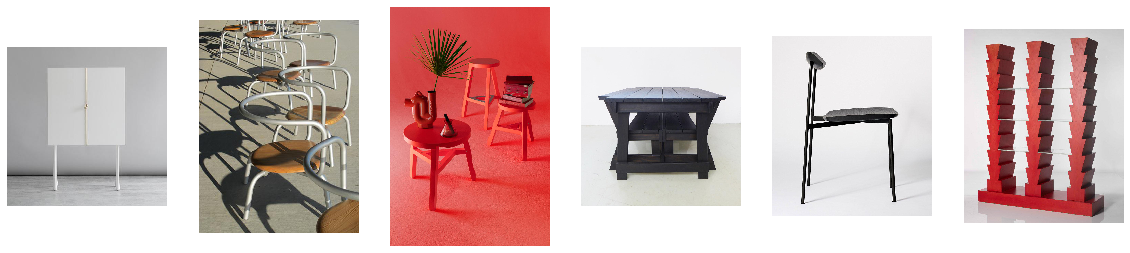


GT labels of neighboring images
[['interior', 'effective', 'outdoor', 'strong', 'deliberate', 'astonishing', 'hard', 'recycled', 'industrial', 'classic', 'current', 'modern', 'old', 'little', 'material', 'innovative', 'original', 'high-pressure', 'perfect', 'future', 'genuine', 'iconic', 'narrow', 'american', 'fashioned', 'subtle', 'bare', 'great', 'analytical', 'nice', 'round', 'spacious', 'thoughtful', 'single-storey', 'real', 'close', 'fixed', 'challenging', 'interested', 'obvious', 'indoor', 'long', 'french', 'fresh', 'public', 'local', 'peculiar', 'physical', 'straightforward'], ['stackable', 'iridescent', 'swedish', 'reflective', 'underpinning', 'big', 'raw', 'frozen', 'extraordinary', 'cheap', 'veritable', 'thin', 'mouth-blown', 'black', 'disposable', 'clear', 'oversized', 'british', 'basic', 'quartz-surface', 'rippled', 'punctured', 'worth', 'unusual', 'round', 'geometric', 'everyday', 'ultimate', 'angular', 'transparent', 'laboratory-style', 'luminous', 'oily', 'concentric'],

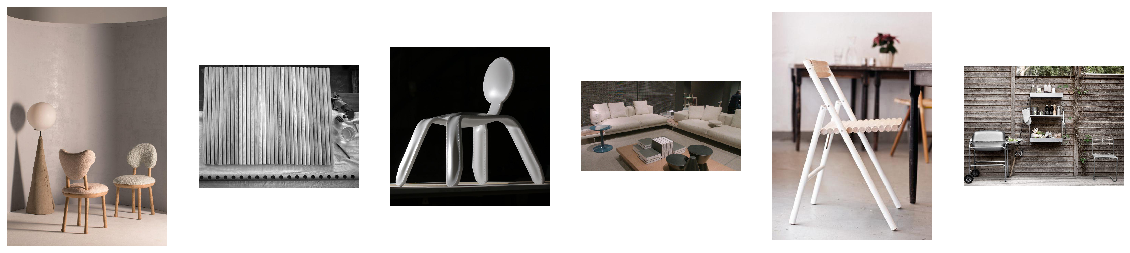


GT labels of neighboring images
[['native', 'exciting', 'hard', 'natural', 'industrial', 'english', 'visual', 'individualistic', 'absolute', 'back-r', 'hand-woven', 'simple', 'conventional', 'personal', 'contemporary', 'familiar', 'respective', 'extraordinary', 'wooden', 'traditional', 'unlimited', 'ceramic', 'utilitarian', 'inherent', 'time-honoured', 'british', 'individual', 'upholstered', 'small', 'fine', 'hand-crafted', 'ladder-', 'long-standing', 'unusual', 'round', 'precious', 'real', 'decent', 'different', 'light', 'limited', 'beautiful', 'standard', 'spindle-back', 'perpendicular', 'angled'], ['exciting', 'refined', 'hard', 'natural', 'soft', 'non-porous', 'thermoformable', 'digital', 'balloon-like', 'wooden', 'future', 'organic', 'stain-resitant', 'composite', 'full-scale', 'heated', 'advanced', 'different', 'inflated', 'interested', 'happy', 'acrylic', 'solid'], ['oval', 'contemporary', 'different', 'aesthetic', 'special', 'small', 'italian', 'low', 'wooden', 'dock', 'standa

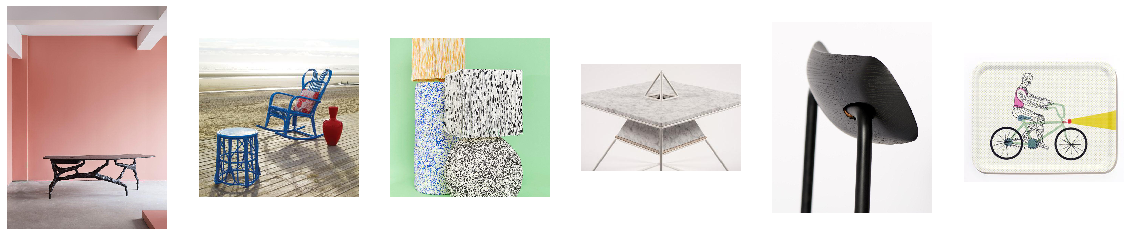


GT labels of neighboring images
[['woolly', 'curved', 'particular', 'coherent', 'gritty', 'strong', 'passionate', 'continental', 'least', 'interesting', 'natural', 'italian', 'single', 'inspiring', 'lovely', 'british-made', 'diluted', 'expensive', 'original', 'confused', 'well-priced', 'full', 'collaborative', 'open', 'studio-designed', 'japanese', 'hand-finished', 'about', 'general', 'american', 'comfortable', 'good', 'british', 'high-street', 'special', 'small', 'great', 'fantastic', 'in-house', 'cultural', 'unusual', 'family-run', 'involved', 'nice', 'wonderful', 'spacious', 'real', 'creative', 'lifestyle-oriented', 'different', 'major', 'hand-made', 'then-exotic', 'gorgeous', 'beautiful', 'colourful', 'mixed', 'three-seat', 'chubby'], ['multidisciplinary', 'particular', 'functional', 'new', 'fantastical', 'environmental', 'brooklyn-based', 'petroleum-based', 'plump', 'slow', 'modern', 'textured', 'opaque', 'hand-blown', 'multi-coloured', 'marbled', 'knotted', 'coloured', 'clear', 

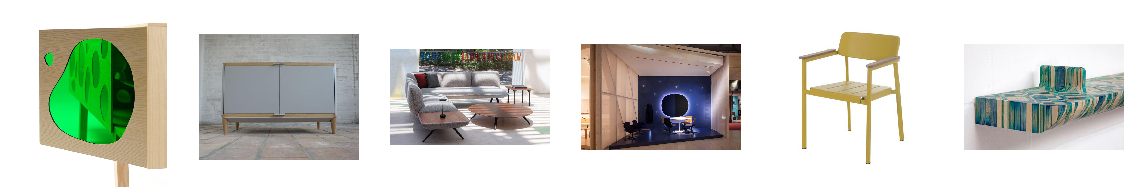


GT labels of neighboring images
[['magnetic', 'different', 'structural', 'two-part', 'super-strong', 'basic', 'little', 'high', 'top', 'fine', 'wooden', 'economical', 'low-grade', 'solid', 'flat-packed', 'friendly', 'sheet-steel', 'straightforward'], ['flat', 'curved', 'fusa', 'italian', 'venetian', 'modern', 'little', 'rounded', 'universal', 'commercial', 'adaptable', 'open', 'modular', 'american', 'matte', 'circular', 'diverse', 'upholstered', 'polished', 'gentle', 'domestic', 'large', 'rectangular', 'freestanding', 'public', 'colourful', 'black', 'classical', 'angled', 'customisable', 'solid', 'corporate'], ['rich', 'dark-blue', 'low', 'pale', 'single', 'single-hued', 'essential', 'vibrant', 'pale-orange', 'dutch', 'multicoloured', 'traditional', 'thin', 'individual', 'muted', 'serious', 'lemon-yellow', 'spanish', 'creative', 'different', 'semi-transparent', 'global', 'representative', 'minimal'], ['stackable', 'paris-based', 'outdoor', 'italian', 'white', 'low', 'resistent', 'wood

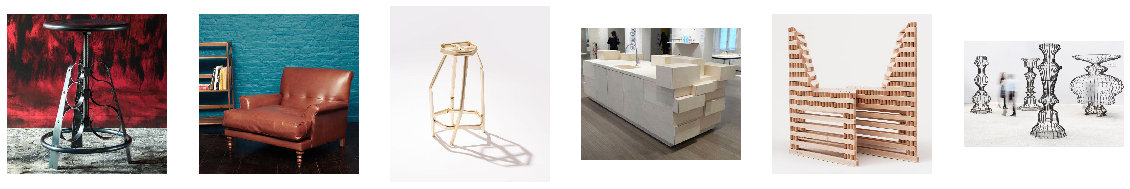


GT labels of neighboring images
[['tilted', 'thorough', 'perfect', 'neat', 'traditional', 'iconic', 'economic', 'time-honoured', 'narrow', 'comfortable', 'oval', 'british', 'upholstered', 'reminiscent', 'legged', 'beautiful', 'black', 'luminous', 'straight', 'double', 'firm', 'sweet', 'low', 'natural', 'single', 'little', 'simple', 'anodised', 'pleased', 'playful', 'modular', 'slender', 'sustainable', 'distinctive', 'delicate', 'round', 'large', 'long', 'actual', 'scottish', 'european', 'rubberised', 'crisp', 'occasional', 'welsh', 'strong', 'white', 'fluorescent', 'clean', 'innovative', 'reserved', 'extensive', 'wide', 'small', 'high', 'top', 'cushioned', 'accurate', 'front', 'continued', 'lightweight', 'sturdy', 'minimal', 'robust', 'pleasing', 'hardwearing', 'pure', 'petite', 'charming', 'current', 'notable', 'elliptical', 'full', 'wooden', 'tall', 'sweeping', 'individual', 'waterproof', 'handy', 'light', 'present', 'fresh', 'multi-layered', 'solid'], ['iridescent', 'aluminium', 'o

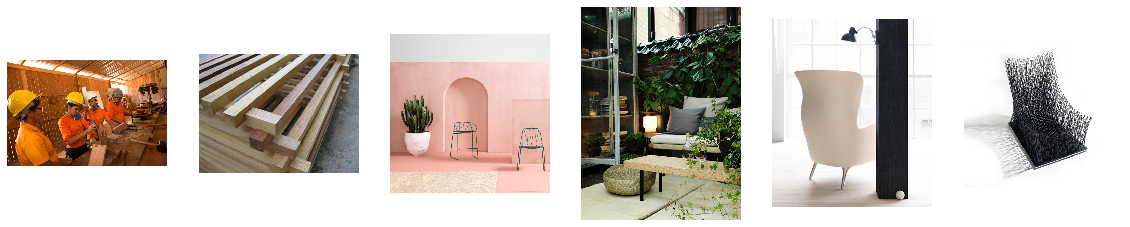


GT labels of neighboring images
[['interior', 'different', 'thin', 'old', 'efficient'], ['curved', 'outdoor', 'industrial', 'promising', 'australian', 'big', 'old', 'simple', 'mutual', 'international', 'thick', 'office-themed', 'anodised', 'wooden', 'thin', 'blue', 'non-electric', 'regular', 'young', 'calm', 'positive', 'folded', 'architectural', 'smile-like', 'standard', 'seafront', 'cylindrical', 'green'], ['flat', 'swedish', 'vast', 'low', 'interesting', 'natural', 'acoustic', 'missing', 'typical', 'weathered', 'hand-blown', 'thick', 'smart', 'thin', 'appealing', 'tight', 'ceramic', 'predominant', 'scientific', 'special', 'small', 'great', 'fantastic', 'fascinating', 'neutral', 'large', 'different', 'sinnerlig', 'determined', 'cork-covered', 'physical'], ['curved', 'pleasing', 'functional', 'world-renowned', 'aesthetic', 'outdoor', 'yellow', 'hard', 'soft', 'visual', 'inner', 'elegant', 'simple', 'rounded', 'vibrant', 'hectic', 'busy', 'traditional', 'quiet', 'coloured', 'blue', 's

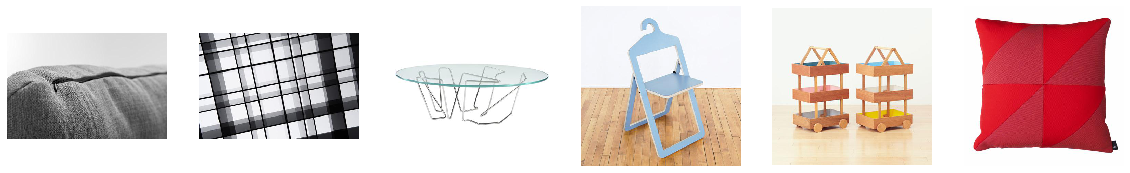


GT labels of neighboring images
[['thick', 'strong', 'visual', 'glossy', 'transparent', '‘opaque', 'kaleidoscopic', 'japanese', 'black'], ['combined', 'exhaustive', 'hard', 'four-year', 'superb', 'chic', 'modern', 'old', 'eclectic', 'nearby', 'unequalled', 'contemporary', 'further', 'legendary', 'full', 'ten-year', 'homeless', 'rare', 'pleased', 'pitt-pollaro', 'realistic', 'complete', 'satisfied', 'confident', 'high', 'fine', 'overall', 'common', 'structural', 'limited', 'accessory', 'custom-made', 'long', 'private', 'decorative'], ['inflatable', 'ultimate', 'contemporary', 'interior', 'unused', 'canadian', 'modest', 'toronto-based', 'orderly', 'precious'], ['bottom', 'moveable', 'blue', 'individual', 'yellow', 'pink', 'white', 'grey', 'wooden', 'japanese', 'dark', 'little', 'colour-coded', 'green'], ['flat', 'coherent', 'current', 'simple', 'sprung', 'double-leaf', 'wooden', 'blue', 'coloured', 'concertinaed', 'twisted', 'modular', 'blocky', 'individual', 'upholstered', 'high', 'pat

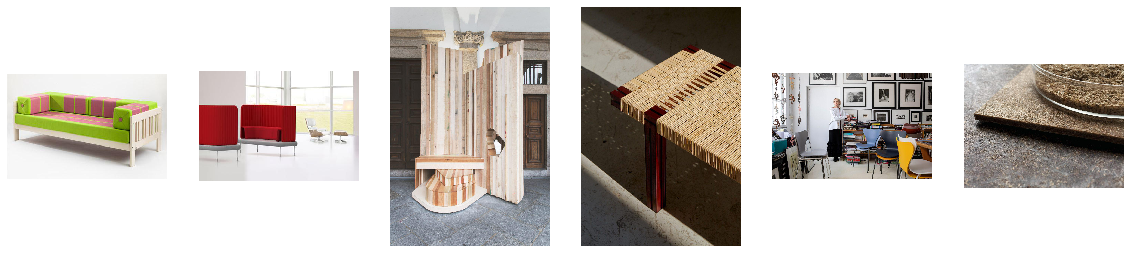


GT labels of neighboring images
[['york-based', 'effective', 'vast', 'hard', 'natural', 'industrial', 'engaged', 'soft', 'relevant', 'big', 'focused', 'shared', 'collaborative', 'fluid', 'traditional', 'productive', 'modular', 'clear', 'integrated', 'good', 'free', 'spontaneous', 'desirable', 'human-centered', 'individual', 'executive', 'fundamental', 'continuous', 'worth', 'casual', 'flexible', 'ideal', 'ergonomic', 'interstitial', 'close', 'large', 'different', 'well', 'remote', 'superficial', 'social', 'public', 'technical', 'fuseproject', 'human'], ['curved', 'italian', 'modern', 'fashionable', 'diamond-shaped', 'full', 'open', 'useful', 'wooden', 'picky', 'middle', 'tubular', 'playful', 'popular', 'elaborate', 'american', 'figurative', 'good', 'sustainable', 'università', 'small', 'sculptural', 'fussy', 'real', 'immaterial', 'versatile', 'beautiful', 'mist-filled', 'interactive', 'private', 'animated', 'decorative'], ['communal', 'functional', 'industrial', 'cloud-based', 'moder

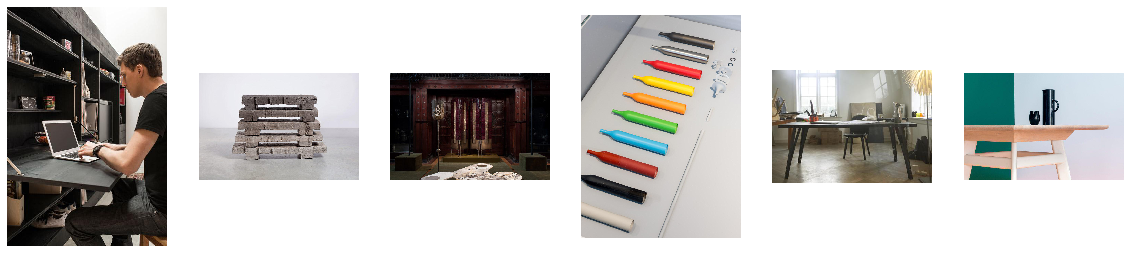


GT labels of neighboring images
[['valuable', 'contested', 'natural', 'ghent-based', 'chemical', 'textured', 'man-made', 'dominant', 'dutch', 'prehistoric', 'narrow', 'abstract', 'concrete', 'rugged', 'unexpected', 'round', 'rectangular', 'non-essential', 'neolithic', 'human'], ['modernist', 'synesthetic', 'central', 'imagined', 'limited-edition', 'melodic', 'persian', 'unique', 'strict', 'rounded', 'contemporary', 'kaleidoscopic', 'musical', 'airy', 'elaborate', 'organic', 'small', 'embroidered', 'reminiscent', 'dark', 'dimensional', 'large', 'light', 'metallic', 'compositional', 'decorative'], ['rich', 'german', 'swedish', 'italian', 'industrial', 'huge', 'textured', 'specialised', 'responsible', 'broad', 'british', 'retail', 'special', 'tactile', 'gentle', 'spanish', 'architectural', 'early', 'retrospective', 'fresh'], ['functional', 'two-shell', 'honest', 'classic', 'single', 'visible', 'big', 'absolute', 'standing', 'elegant', 'unique', 'simple', 'rounded', 'contemporary', 'ample

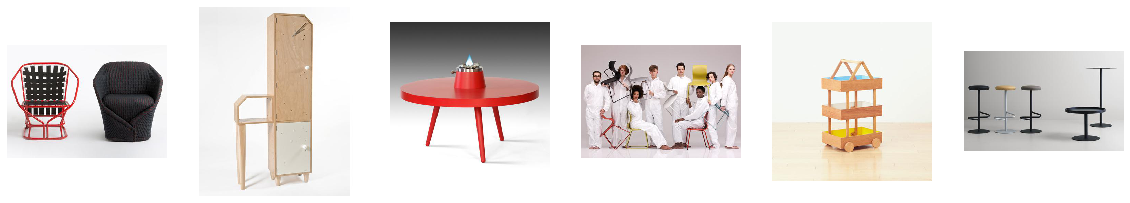


GT labels of neighboring images
[['change-inspired', 'wooden', 'full', 'modular'], ['alive', 'valuable', 'low', 'hard', 'enamelled', 'big', 'contemporary', 'hand-painted', 'international', 'hand-carved', 'emotional', 'traditional', 'overlooked', 'brown', 'cultural', 'red', 'mixed', 'obsolete', 'custom-made', 'hungarian', 'black'], ['contemporary', 'different', 'german', 'innovative', 'functional', 'light', 'universal', 'italian', 'strong', 'basic', 'special', 'scientific', 'pro', 'industrial', 'private', 'friendly'], ['bottom', 'moveable', 'blue', 'individual', 'yellow', 'pink', 'white', 'grey', 'wooden', 'japanese', 'dark', 'little', 'colour-coded', 'green'], ['simple', 'circular', 'oval', 'large', 'lacquered', 'swedish', 'high', 'interchangeable', 'top', 'square', 'round', 'little', 'popular']]

Clustering
[[], [], ['italian'], [], []]
Total predicted:  1
-----------------------

query in neighbors!
-----NEW QUERY------

true labels:  ['rich', 'chief', 'firm', 'revolutionary', 'exte

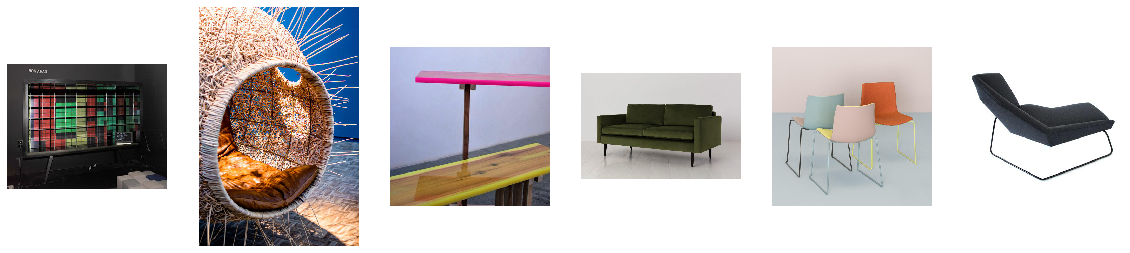


GT labels of neighboring images
[['dead', 'white', 'hard', 'furry', 'brown-leather', 'technological', 'collectible', 'relevant', 'south', 'animal-shaped', 'grey', 'wooden', 'traditional', 'killer-whale-shaped', 'plush-lined', 'black', 'dorsal', 'egg-shaped', 'four-legged', 'loopy', 'deep', 'red', 'non-traditional', 'southern', 'ongoing', 'creative', 'different', 'stitched', 'pink', 'enlarged', 'tongue-shaped', 'local', 'african'], ['flat', 'intense', 'contemporary', 'japanese', 'different', 'legged', 'wooden', 'traditional', 'fluorescent', 'coloured'], ['flat', 'flat-pack', 'complete', 'logistical', 'home-assembly', 'additional', 'three-seater', 'two-seater', 'small', 'basic', 'structural', 'extensive', 'future', 'swyft-lok', 'triple-layered', 'grooved', 'solid', 'die-cast'], ['stiff', 'flat-pack', 'curved', 'german', 'swedish', 'sound-absorbing', 'elegant', 'intelligent', 'weird', 'minimalist', 'generic', 'traditional', 'japanese', 'iconic', 'coloured', 'square', 'finnish', 'integrat

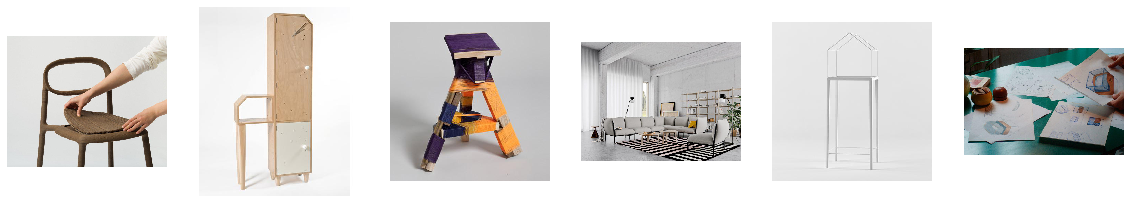


GT labels of neighboring images
[['change-inspired', 'wooden', 'full', 'modular'], ['triangular', 'different', 'light', 'chilean', 'additional', 'custom-made', 'full', 'tiny', 'glue-coated', 'interactive', 'independent', 'mechanical', 'computer-generated'], ['stackable', 'flat', 'woollen', 'curved', 'striped', 'cologne-based', 'swedish', 'strong', 'italian', 'least', 'powder-coated', 'single', 'big', 'last', 'joyful', 'simple', 'norwegian', 'alphabeta', 'inaugural', 'three-seater', 'innovative', 'international', 'prolific', 'three-metre-long', 'orderly', 'popular', 'modular', 'three-dimensional', 'running', 'in-house', 'experimental', 'textile', 'high-end', 'nice', 'geometric', 'different', 'true', 'loose', 'floor-lamp', 'detachable', 'french', 'standard', 'pro', 'lightweight', 'milan-based', 'temporary'], ['wall-mounted', 'different', 'three-legged', 'small', 'white', 'mechanical', 'house-shaped', 'wooden', 'secret', 'ceramic', 'black', 'tall', 'naive'], ['night-time', 'desperate', '

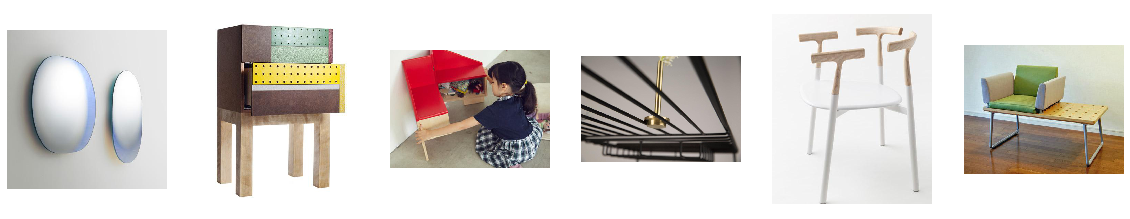


GT labels of neighboring images
[['interior', 'northern', 'swedish', 'sweden-based', 'urban', 'rundvik', 'last', 'old', 'artistic', 'original', 'entrepreneurial', 'first', 'lifelong', 'active', 'successful', 'unusual', 'domestic', 'close', 'large', 'different', 'present', 'long', 'timeless'], ['good', 'hollow', 'versatile', 'multifunctional', 'original', 'london-based', 'small', 'disabled', 'long', 'tiny', 'white', 'distinct', 'open', 'slanted', 'surprised', 'red', 'easy', 'miniature'], ['circular', 'slender', 'good', 'line-drawn', 'suited', 'tubular', 'active', 'rectangular', 'small', 'wooden', 'thin', 'gridded', 'black', 'passive', 'grooved', 'modular', 'pleasurable'], ['different', 'italian', 'high', 'interchangeable', 'white', 'low', 'wooden', 'connected', 'artificial', 'prolific', 'japanese', 'minimal'], ['timemodular', 'different', 'upholstered', 'small', 'single-occupant', 'young', 'japanese', 'modular']]

Clustering
[['different'], [], [], ['different', 'low', 'japanese'], ['d

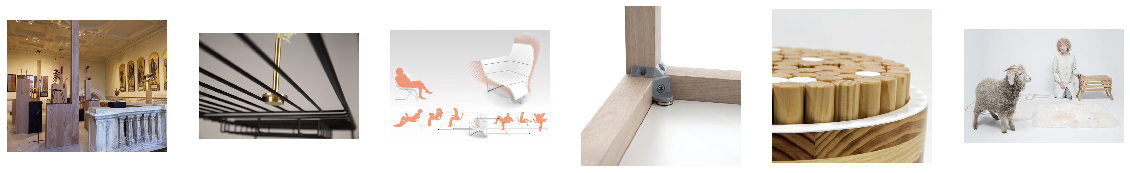


GT labels of neighboring images
[['circular', 'slender', 'good', 'line-drawn', 'suited', 'tubular', 'active', 'rectangular', 'small', 'wooden', 'thin', 'gridded', 'black', 'passive', 'grooved', 'modular', 'pleasurable'], ['curvilinear', 'beige', 'soft', 'single', 'visual', 'semi-public', 'dutch', 'nonsymmetrical', 'wide', 'spatial', 'individual', 'small', 'upholstered', 'matching', 'direct', 'orange', 'asymmetric', 'different', 'stretch', 'contoured', 'public', 'private', 'solid'], ['domestic', 'plastic', 'closed', 'light', 'german', 'load-bearing', 'invisible', 'dark', 'complex', 'nordic', 'outdoor', 'open', 'wooden', 'swinging', '‘hidden', 'elegant', 'back'], ['ready', 'white', 'industrial', 'pine', 'simple', 'layered', 'vertical', 'zig-zag', 'wooden', 'comfortable', 'integrated', 'high', 'top', 'positive', 'textile', 'unfixed', 'ergonomic', 'blown-glass', 'cross-laminated', 'contoured', 'black'], ['woollen', 'boundless', 'natural', 'multiple', 'full-length', 'dutch', 'future', 'fol

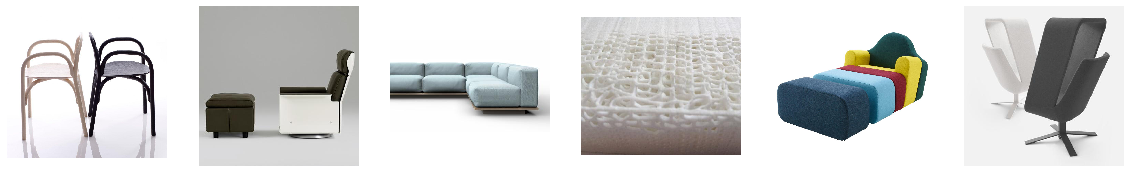


GT labels of neighboring images
[['exclusive', 'worldwide', 'german', 'multi-seat', 'exceptional', 'classic', 'single', 'full-grain', 'last', 'universal', 'sumptuous', 'original', 'adaptable', 'rare', 'traditional', 'pleased', 'carefully-conceived', 'swivel', 'characteristic', 'aniline-dyed', 'purpose-designed', 'global', 'lengthy'], ['philosophical', 'chief', 'different', 'informal', 'swedish', 'full', 'indoor', 'fascinating', 'residential', 'casual', 'milan-based', 'fit'], ['particular', 'strong', 'soft', 'single', 'little', 'conventional', 'multi-coloured', 'biological', 'rigid', 'good', 'sustainable', 'conceptual', 'sophisticated', 'upholstered', 'great', 'flexible', 'normal', 'efficient', 'different', 'structural'], ['curved', 'accessible', 'horizontal', 'yellow', 'rounded', 'contemporary', 'original', 'blue', 'coloured', 'modular', 'enhanced', 'additional', 'direct', 'alphabet-shaped', 'different', 'rectangular', 'french', 'happy', 'rust-patterned', 'classical', 'angled', 'green

173

In [155]:
image_retrieval(all_embeds, val_dataloader)

## CLUSTER

In [85]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.cm as cm
import matplotlib

In [93]:
IMAGE_EMBEDDINGS = open_json('IMAGE_EMBEDDINGS_OFFTHESHELF_RESNET.json')

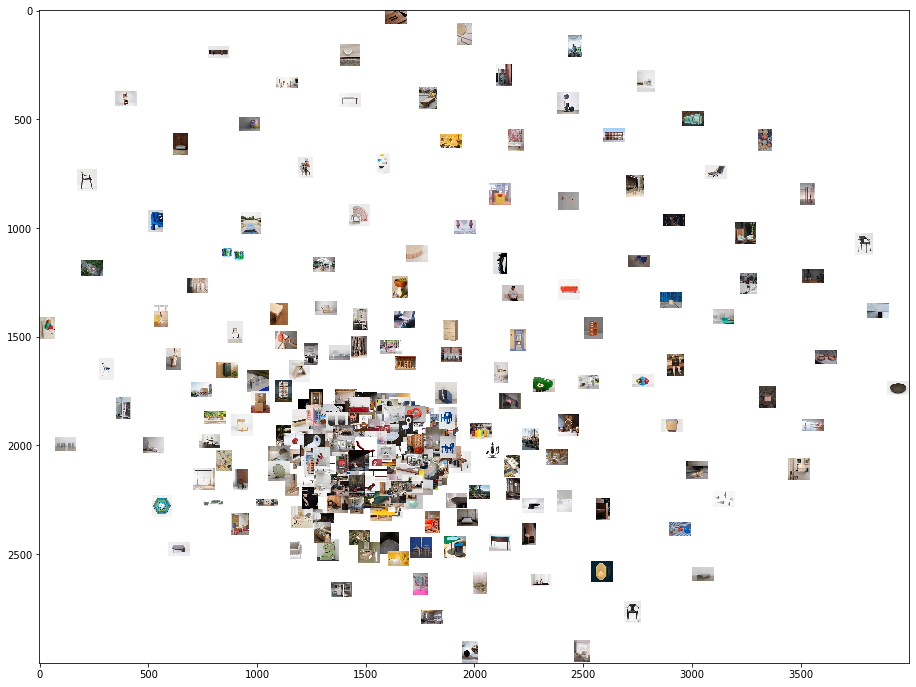

In [94]:
def plot_cluster(im_features):
    #im_embeddings_np = np.asarray(im_features[:1000, :]) # [1000, 2048]
    im_embeddings_np = im_features[:1200, :]
    tsne = TSNE(n_components=2, learning_rate=150).fit_transform(im_embeddings_np)
    return tsne

im_embds_emb = list(IMAGE_EMBEDDINGS.values()) # embeddings
im_embds_names = list(IMAGE_EMBEDDINGS.keys()) # embeddings
im_embds_names = im_embds_names[:1200]

im_embeddings_np = np.asarray(im_embds_emb).squeeze(1) # [17532, 50]
tsne = plot_cluster(im_embeddings_np) # [1000, 2]

# Normalize in the range (0,1)
tx, ty = tsne[:, 0], tsne[:, 1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

images = [im_path_fur + '/' + im for im in im_embds_names]

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
ii = 0
# font_path = '/System/Library/Fonts/Times.ttc'
# font = PIL.ImageFont.truetype(font_path, size=100)
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
#     draw = ImageDraw.Draw(tile)
#     draw.text((50,50), mc_labels[ii].encode("utf-8").decode("latin1"),fill='black', font=font)
#     tile = tile
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
    ii +=1
matplotlib.pyplot.figure(figsize = (16,12))
matplotlib.pyplot.imshow(full_image)
full_image.save("tSNE-offtheshelf_resnet.png")